<a href="https://colab.research.google.com/github/Hulyacerit/genetik_optimizasyonu/blob/main/YapayZeka_1_Odev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ad: Hülya
Soyad: Cerit

---


Okul Numarası: 2312721012

---


Github Repo Bağlantısı: https://github.com/Hulyacerit/genetik_optimizasyonu.git

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- AMAÇ FONKSİYONU ---
def tahmin_y(birey):
    """
    x1 ve x2'yi bireyden okuyacak.
    """
    x1 = birey[0]
    x2 = birey[1]
    y = 5 * x1 + 2 * x2 - (x1 * x2) #Fonksiyon tanımlaması
    return y

# --- KISIT KONTROLÜ ---
def kısıt_kontrol(birey):
    """
    Tekrar: Hem x1+x2=100 hem de x1 >= 30 kısıtlarını kontrol eder.
    """
    ihlal_sayisi = 0
    x1 = birey[0]
    x2 = birey[1]

    # Kısıt 1: x1 + x2 = 100 olmalı (0.1 tolerans ile)
    if abs((x1 + x2) - 100) > 0.1:
        ihlal_sayisi += 1

    # Kısıt 2: x1 en az 30 olmalı
    if x1 < 30:
        ihlal_sayisi += 1

    return ihlal_sayisi

In [2]:
def uygunluk_hesapla(birey):
    """
    Uygunluk (Fitness) = Amaç Değeri - Ceza Puanı
    """
    y_degeri = tahmin_y(birey) #y değerini fonksiyona görre bulmak için

    # İhlal sayısını 10 ile çarparak cezayı hesapla
    ceza = kısıt_kontrol(birey) * 10

    # Puanı hesaplama
    return y_degeri - ceza

In [3]:
def rulet_secimi(populasyon, uygunluklar, adet=2):
    # Negatif puanları pozitife çevirerek olasılık hesapla
    min_val = np.min(uygunluklar)  #popülasyondaki en düşük uygunluk değerini bulur.
    pozitif_uygunluklar = uygunluklar - min_val + 1e-6 #her uygunluk değerinden, en düşük uygunluk değeri çıkarılır.
                                                       #1e-6 en kötü bireyin uygun değerinin sıfır olmasını engeller.
    toplam = np.sum(pozitif_uygunluklar)
    olasiliklar = pozitif_uygunluklar / toplam
    secilen_indeksler = np.random.choice(len(populasyon), size=adet, p=olasiliklar)
    return populasyon[secilen_indeksler]

def rank_temelli_secim(populasyon, uygunluklar, adet=2):
    N = len(populasyon)
    # Uygunluk değerine göre küçükten büyüğe sıralama yapar
    sirali_indeksler = np.argsort(uygunluklar)

    # Sıralamaya göre seçilme ihtimali atar (İyi olanın şansı yüksek olur)
    payda = N * (N + 1) / 2
    secim_ihtimalleri = np.array([(i + 1) / payda for i in range(N)])

    ihtimaller = np.zeros(N)
    for i, idx in enumerate(sirali_indeksler):
        ihtimaller[idx] = secim_ihtimalleri[i]
    ihtimaller = ihtimaller / ihtimaller.sum()

    secilen_indeksler = np.random.choice(N, size=adet, p=ihtimaller)
    return populasyon[secilen_indeksler]

In [4]:
def tek_noktali_caprazlama(p1, p2):
    """

    Bu, kısıt ihlali yapacaktır, bu yüzden uygunluk fonksiyonunda ceza olacak.
    """
    # Tek nokta, genler arasında kesme yapar. len(p1)=2 ise, nokta=1 olur.
    nokta = random.randint(1, len(p1)-1)

    # Çocuk 1: p1'in başlangıcı + p2'nin sonu
    c1 = np.concatenate((p1[:nokta], p2[nokta:]))
    # Çocuk 2: p2'nin başlangıcı + p1'in sonu
    c2 = np.concatenate((p2[:nokta], p1[nokta:]))

    return c1, c2

def mutasyon_uygula(birey, ihtimal, buyukluk):
    """
    Tekrar: İki gene de mutasyon uygularız.
    """
    yeni = birey.copy()
    for i in range(len(yeni)):
        if np.random.rand() < ihtimal:
            degisim = buyukluk * (np.random.rand() - 0.5) * 20
            yeni[i] += degisim

    # Kısıtları korumadığı için, sadece genel 0-100 aralığına klipleme yapılıyor.
    return np.clip(yeni, 0, 100)

In [5]:
def evrimsel_algoritma(populasyon, nesil_sayisi, secim_turu, mutasyon_ihtimali, mutasyon_buyuklugu):

    en_iyiler = []
    global_en_iyi_birey = None
    global_en_iyi_skor = -float('inf')

    print(f"   Genetik Algoritma Başlıyor...")
    print(f"   Yöntem: Akıllı Başlangıç (Kısıtlara uygun bireylerle başlandı)")
    print(f"   Ceza Kuralı: Her ihlal için 10 puan.\n")

    for nesil in range(nesil_sayisi):
        uygunluklar = np.array([uygunluk_hesapla(b) for b in populasyon])

        # En iyi bireyi bulma (Elitizm)
        en_iyi_indeks = np.argmax(uygunluklar)
        elit_birey = populasyon[en_iyi_indeks].copy()
        elit_skor = uygunluklar[en_iyi_indeks]

        en_iyiler.append(elit_skor)

        if elit_skor > global_en_iyi_skor:
            global_en_iyi_skor = elit_skor
            global_en_iyi_birey = elit_birey.copy()

        # Her 10 nesilde bir rapor yazdırılır
        if nesil % 10 == 0:
            x1_val = elit_birey[0]
            x2_val = 100 - x1_val # x2'yi burada hesaplanır
            y_val = tahmin_y(elit_birey)
            ihlaller = kısıt_kontrol(elit_birey)
            print(f"Nesil {nesil}: x1={x1_val:.1f}, x2={x2_val:.1f} | Y={y_val:.1f} | İhlal={ihlaller} | Fit={elit_skor:.1f}")

        # Seçim Havuzu Oluşturuldu
        havuz = []
        for _ in range(len(populasyon) // 2):
            if secim_turu == "rank":
                ebeveynler = rank_temelli_secim(populasyon, uygunluklar)
            else:
                ebeveynler = rulet_secimi(populasyon, uygunluklar)
            havuz.append(ebeveynler)

        # Çaprazlama ve Mutasyon ile Yeni Nesil Üretildi
        yeni_bireyler = [elit_birey]
        while len(yeni_bireyler) < len(populasyon):
            idx = random.randint(0, len(havuz)-1)
            p1, p2 = havuz[idx]
            c1, c2 = tek_noktali_caprazlama(p1, p2)
            c1 = mutasyon_uygula(c1, mutasyon_ihtimali, mutasyon_buyuklugu)
            c2 = mutasyon_uygula(c2, mutasyon_ihtimali, mutasyon_buyuklugu)
            yeni_bireyler.extend([c1, c2])

        populasyon = np.array(yeni_bireyler[:len(populasyon)])

    # Sonuçlar Gösterildi ve Grafik Çizildi
    print("\n---------------- SONUÇLAR ----------------")
    x1 = global_en_iyi_birey[0]
    x2 = 100 - x1 # x2'yi burada hesaplandı
    print(f"🏆 En İyi Karışım:")
    print(f"   Pigment A (x1): %{x1:.2f}")
    print(f"   Pigment B (x2): %{x2:.2f}")
    print(f"   Toplam: %{x1+x2:.2f}")
    print(f"   Amaç Fonksiyonu (y): {tahmin_y(global_en_iyi_birey):.2f}")
    print(f"   İhlal Sayısı: {kısıt_kontrol(global_en_iyi_birey)}")

    plt.plot(en_iyiler)
    plt.title("Genetik Algoritma Başarısı (Akıllı Başlangıç)")
    plt.xlabel("Nesil")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.show()

In [6]:
def akilli_populasyon_olustur(birey_sayisi):
    """
    Fonksiyon, her yeni bireyi oluştururken problemdeki temel kısıtları uygulayarak, algoritmanın ilk nesilde gereksiz cezalar almasını engeller3
    ve optimuma çok daha hızlı yakınlaşmasını sağlar.
    """
    populasyon = []
    for _ in range(birey_sayisi):
        # Kısıt 2: x1 en az 30 olmalı
        x1 = random.uniform(30, 100)
        # Kısıt 1: x2 = 100 - x1
        x2 = 100 - x1
        populasyon.append([x1, x2])
    return np.array(populasyon)

🚀 Popülasyon akıllı yöntemle oluşturuluyor...
🧬 Genetik Algoritma Başlıyor...
   Yöntem: Akıllı Başlangıç (Kısıtlara uygun bireylerle başlandı)
   Ceza Kuralı: Her ihlal için 10 puan.

Nesil 0: x1=97.7, x2=2.3 | Y=272.2 | İhlal=0 | Fit=272.2
Nesil 10: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0
Nesil 20: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0
Nesil 30: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0
Nesil 40: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0
Nesil 50: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0
Nesil 60: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0
Nesil 70: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0
Nesil 80: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0
Nesil 90: x1=100.0, x2=0.0 | Y=500.0 | İhlal=0 | Fit=500.0

---------------- SONUÇLAR ----------------
🏆 En İyi Karışım:
   Pigment A (x1): %100.00
   Pigment B (x2): %0.00
   Toplam: %100.00
   Amaç Fonksiyonu (y): 500.00
   İhlal Sayısı: 0


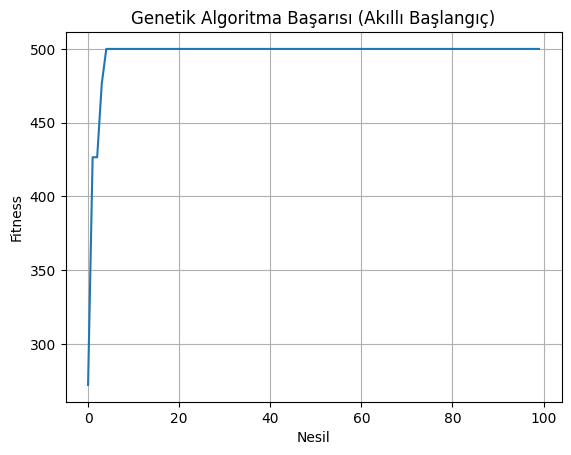

In [11]:
# --- PARAMETRELER ---
NESIL_SAYISI = 100
SECIM_TURU = "rank"
MUTASYON_IHTIMALI = 0.5
MUTASYON_BUYUKLUGU = 1.0
POPULASYON_BOYUTU = 50

# ADIM 1: Popülasyonu Akıllı Fonksiyonla Oluştur
print("🚀 Popülasyon akıllı yöntemle oluşturuluyor...")
populasyon = akilli_populasyon_olustur(POPULASYON_BOYUTU)

# ADIM 2: Algoritmayı Çalıştır
evrimsel_algoritma(
    populasyon=populasyon,
    nesil_sayisi=NESIL_SAYISI,
    secim_turu=SECIM_TURU,
    mutasyon_ihtimali=MUTASYON_IHTIMALI,
    mutasyon_buyuklugu=MUTASYON_BUYUKLUGU
)